<h1><center>Querying RB Voltage Feelers during a ramp-up</center></h1>

# 0. Initialise the working environment
## 0.1 Install required packages for SWAN

In [1]:
import sys
if sys.version_info < (3,0):
    raise Warning("Not available for Python2. Compatible with Python3 only!")

!{sys.executable} -m pip install --user --upgrade tzlocal
!{sys.executable} -m pip install --user --upgrade lhcsmapi
!{sys.executable} -m pip install --user --upgrade influxdb

Requirement already up-to-date: tzlocal in /eos/home-m/mmacieje/.local/lib/python3.6/site-packages (2.0.0)
Requirement already up-to-date: lhcsmapi in /eos/home-m/mmacieje/.local/lib/python3.6/site-packages (1.1.11)
Requirement already up-to-date: influxdb in /eos/home-m/mmacieje/.local/lib/python3.6/site-packages (5.2.2)


## 0.2 Import useful packages

In [1]:
import pandas as pd
import numpy as np
import scipy
import datetime as dt
from dateutil.relativedelta import relativedelta
import pytimber
ldb = pytimber.LoggingDB()
from numpy import linalg as LA

from lhcsmapi.dbsignal.Signal import Signal
from lhcsmapi.dbsignal.SignalUtilities import SignalUtilities
from lhcsmapi.dbsignal.SignalAnalysis import SignalAnalysis
from lhcsmapi.cals.CalsDbSignal import CalsDbSignal
from lhcsmapi.Time import Time
from lhcsmapi.metadata.Metadata import Metadata

# 1. Choose a day and component to analyse

In [3]:
selectedYear = 2018
selectedMonth = 8
selectedDay = 18
incrementYear = 0
incrementMonth = 0
incrementDay = 3

circuit = 'RB'
sector = 'RB.A12'

# 2. Get ramp-ups for a given start date and duration
- Prepare metadata
- Prepare query duration

In [4]:
circuitToSectorMetadata = Metadata.getMetadata(circuit, sector)
metadata = circuitToSectorMetadata[sector]

circuitName = metadata['PC_NAME']

startDate = dt.datetime(selectedYear, selectedMonth, selectedDay)
endDate = startDate + relativedelta(years = +incrementYear)\
                    + relativedelta(months = +incrementMonth)\
                    + relativedelta(days = +incrementDay)

## 3. Find a beam mode pattern for ramp-up
## 3.1. Query beam mode

In [5]:
bModeName = Metadata.BMODE
bModeDf = CalsDbSignal.get_signal(signal=bModeName, t_start = startDate, t_end = endDate, ldb = ldb)
bModeSeries = bModeDf[bModeName]
bModeSeries

1.534592e+09    13.0
1.534592e+09    14.0
1.534594e+09     2.0
1.534594e+09     3.0
1.534595e+09     5.0
1.534596e+09     3.0
1.534596e+09     5.0
1.534598e+09     6.0
1.534598e+09     7.0
1.534599e+09     8.0
1.534599e+09     9.0
1.534600e+09    10.0
1.534600e+09    11.0
1.534641e+09    13.0
1.534641e+09    14.0
1.534643e+09     2.0
1.534649e+09    21.0
1.534652e+09    21.0
1.534656e+09    19.0
1.534658e+09     2.0
1.534659e+09     3.0
1.534660e+09     5.0
1.534662e+09     6.0
1.534662e+09     7.0
1.534663e+09     8.0
1.534663e+09     9.0
1.534664e+09    10.0
1.534664e+09    11.0
1.534711e+09    13.0
1.534711e+09    14.0
1.534712e+09     2.0
1.534714e+09     3.0
1.534715e+09     5.0
1.534716e+09     3.0
1.534716e+09     5.0
1.534717e+09     3.0
1.534718e+09     5.0
1.534720e+09     3.0
1.534724e+09     5.0
1.534726e+09     6.0
1.534726e+09     7.0
1.534727e+09     8.0
1.534727e+09     9.0
1.534728e+09    10.0
1.534729e+09    11.0
1.534776e+09    13.0
1.534776e+09    14.0
1.534778e+09 

## 3.2. Filter a beam mode pattern for ramp-up: [6, 8]
### 3.2.1. Filter rows containing indices in the pattern

In [6]:
pattern = [6.0, 8.0]
bModeWithPatternSeries = bModeSeries[bModeSeries.isin(pattern)]
bModeWithPatternSeries

1.534598e+09    6.0
1.534599e+09    8.0
1.534662e+09    6.0
1.534663e+09    8.0
1.534726e+09    6.0
1.534727e+09    8.0
Name: HX:BMODE, dtype: float64

### 3.2.2. Filter rows containing the exact pattern

In [7]:
exactPatternDf = SignalAnalysis.find_rows_with_exact_pattern_in_series(bModeWithPatternSeries, pattern)
exactPatternDf

6.0           8.0
0  1.534598e+09  1.534599e+09
1  1.534662e+09  1.534663e+09
2  1.534726e+09  1.534727e+09

### 3.2.3. Filter rows containing the pattern with the prescribed duration
- [6, 8] for 100 s, to reach about 10 kA (dI/dt = 10 A/s)

In [8]:
exactPatternDf['isDurationOk'] = (exactPatternDf[8.0] - exactPatternDf[6.0] > 100)
exactPatternDurationOkDf = exactPatternDf.query('isDurationOk == True')
exactPatternDurationOkDf

6.0           8.0  isDurationOk
0  1.534598e+09  1.534599e+09          True
1  1.534662e+09  1.534663e+09          True
2  1.534726e+09  1.534727e+09          True

# 4. Query current during ramp-ups

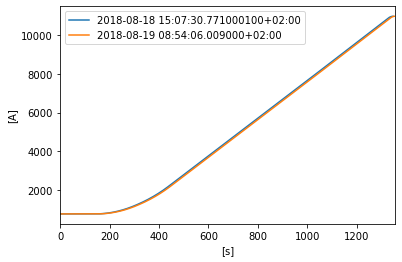

In [9]:
iMeasName = metadata["FGC"]["CALS"]["I_MEAS"]
currentRamp = []
for ix in exactPatternDf.index[0:2]:
    t_start = exactPatternDf.loc[ix, [6.0]].values[0]
    t_end = exactPatternDf.loc[ix, [8.0]].values[0]
    iMeasDf = Signal().read('cals', name = iMeasName, t_start = (t_start, 's'), t_end = (t_end, 's'), ldb = ldb)
    currentRamp.append(SignalUtilities.synchronize_df(iMeasDf, 's'))

# Plot two consecutive current ramp-ups
ax = currentRamp[0].plot() 
currentRamp[1].plot(ax = ax).set(xlabel="[s]", ylabel="[A]")
ax.legend([Time.to_string(exactPatternDf.loc[0, [6.0]].values[0], 's'), 
           Time.to_string(exactPatternDf.loc[1, [6.0]].values[0], 's')]);

# 5. Searching for CALS RB voltage feelers names

In [10]:
# Voltage feelers for left and right of an interaction point
circuitToSystemMetadata = Metadata.getMetadata(circuit, "VF")
vfNamesForSector = circuitToSystemMetadata["VF"]["CIRCUIT_NAME_TO_VF_REG_EXP"][sector]

voltageNames = []
for vfName in vfNamesForSector:
    voltageNames += ldb.search(vfName)
print(voltageNames)

['MB.A10R1:U_EARTH_RB', 'MB.A33R1:U_EARTH_RB', 'MB.A8R1:U_EARTH_RB', 'MB.B11R1:U_EARTH_RB', 'MB.B8R1:U_EARTH_RB', 'MB.C12R1:U_EARTH_RB', 'MB.C13R1:U_EARTH_RB', 'MB.C14R1:U_EARTH_RB', 'MB.C15R1:U_EARTH_RB', 'MB.C16R1:U_EARTH_RB', 'MB.C17R1:U_EARTH_RB', 'MB.C18R1:U_EARTH_RB', 'MB.C19R1:U_EARTH_RB', 'MB.C20R1:U_EARTH_RB', 'MB.C21R1:U_EARTH_RB', 'MB.C22R1:U_EARTH_RB', 'MB.C23R1:U_EARTH_RB', 'MB.C24R1:U_EARTH_RB', 'MB.C25R1:U_EARTH_RB', 'MB.C26R1:U_EARTH_RB', 'MB.C27R1:U_EARTH_RB', 'MB.C28R1:U_EARTH_RB', 'MB.C29R1:U_EARTH_RB', 'MB.C30R1:U_EARTH_RB', 'MB.C31R1:U_EARTH_RB', 'MB.C32R1:U_EARTH_RB', 'MB.C34R1:U_EARTH_RB', 'MB.A10L2:U_EARTH_RB', 'MB.A8L2:U_EARTH_RB', 'MB.B11L2:U_EARTH_RB', 'MB.B8L2:U_EARTH_RB', 'MB.C12L2:U_EARTH_RB', 'MB.C13L2:U_EARTH_RB', 'MB.C14L2:U_EARTH_RB', 'MB.C15L2:U_EARTH_RB', 'MB.C16L2:U_EARTH_RB', 'MB.C17L2:U_EARTH_RB', 'MB.C18L2:U_EARTH_RB', 'MB.C19L2:U_EARTH_RB', 'MB.C20L2:U_EARTH_RB', 'MB.C21L2:U_EARTH_RB', 'MB.C22L2:U_EARTH_RB', 'MB.C23L2:U_EARTH_RB', 'MB.C24L2:U_EA

## 6.1. Get voltage feeler for the first ramp
### 6.1.1. Query CALS 

In [11]:
t_start = exactPatternDf.loc[0, [6.0]].values[0]
t_end = exactPatternDf.loc[0, [8.0]].values[0]

vfFirst = []
for voltageName in voltageNames:
    vfDF = Signal().read('cals', name = voltageName, t_start = (t_start, 's'), t_end = (t_end, 's'), ldb = ldb)
    vfFirst.append(SignalUtilities.synchronize_df(vfDF, 's'))

### 6.1.2. Resample with 10 Hz frequency

In [12]:
vfFirstResampled = []
for vf in vfFirst:
    vfFirstResampled.append(SignalAnalysis.resample(vf, 0.1))

## 6.2. Get voltage feeler for the second ramp
### 6.2.1. Query CALS

In [13]:
t_start = exactPatternDf.loc[1, [6.0]].values[0]
t_end = exactPatternDf.loc[1, [8.0]].values[0]

vfSecond = []
for voltageName in voltageNames:
    vfDF = Signal().read('cals', name = voltageName, t_start = (t_start, 's'), t_end = (t_end, 's'), ldb = ldb)
    vfSecond.append(SignalUtilities.synchronize_df(vfDF, 's'))

### 6.2.2. Resample with 10 Hz frequency

In [14]:
vfSecondResampled = []
for vf in vfSecond:
    vfSecondResampled.append(SignalAnalysis.resample(vf, 0.1))

## 6.3 Cut signals to the shortest one

In [15]:
minLenVFFirst = len(min(vfFirstResampled, key=len))
minLenVFSecond = len(min(vfSecondResampled, key=len))
minLen = min(minLenVFFirst, minLenVFSecond)

### 6.3.1. Cut first ramp signals to the shortest one

In [16]:
vfFirstResampledShortened = []
for vfr in vfFirstResampled:
    vfFirstResampledShortened.append(vfr.iloc[0:minLen])

### 6.3.2. Cut second ramp signals to the shortest one

In [17]:
vfSecondResampledShortened = []
for vfr in vfSecondResampled:
    vfSecondResampledShortened.append(vfr.iloc[0:minLen])

## 6.4. Set index of the first series to the remaining ones (avoids duplication of indices)

### 6.4.1. First ramp-up

In [18]:
vfFirstResampledShortenedSynced = []
for vfrs in vfFirstResampledShortened:
    vfFirstResampledShortenedSynced.append(vfrs.set_index(vfFirstResampledShortened[0].index))

### 6.4.2. Second ramp-up

In [19]:
vfSecondResampledShortenedSynced = []
for vfrs in vfSecondResampledShortened:
    vfSecondResampledShortenedSynced.append(vfrs.set_index(vfSecondResampledShortened[0].index))

## 6.5. Concatenate voltage feeler Series into a DataFrame and plot

### 6.5.1. First ramp-up

<IPython.core.display.Javascript object>


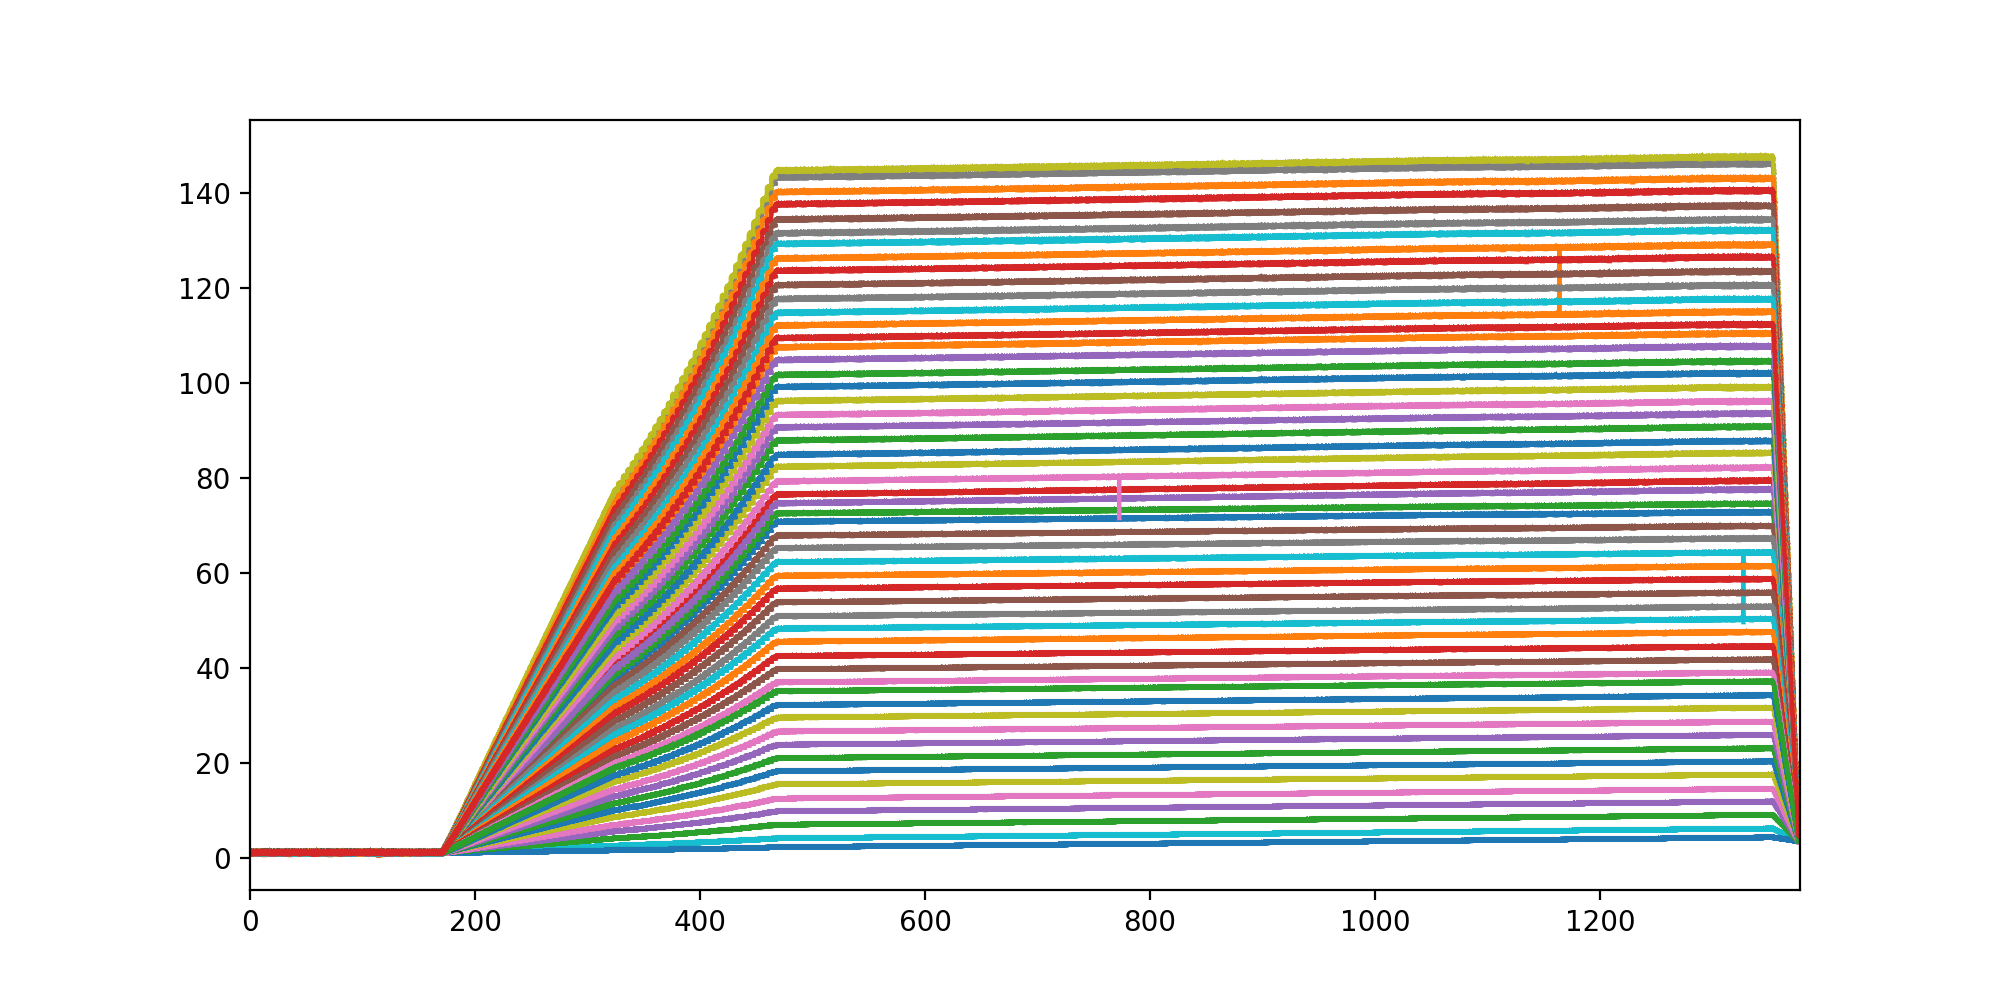

In [20]:
vfFirstResampledShortenedSyncedDf = pd.concat(vfFirstResampledShortenedSynced, axis = 1)
%matplotlib notebook
vfFirstResampledShortenedSyncedDf.plot(figsize=(10, 5), style='^-', markersize=0.3, legend=False)

### 6.5.2. Second ramp-up

<IPython.core.display.Javascript object>


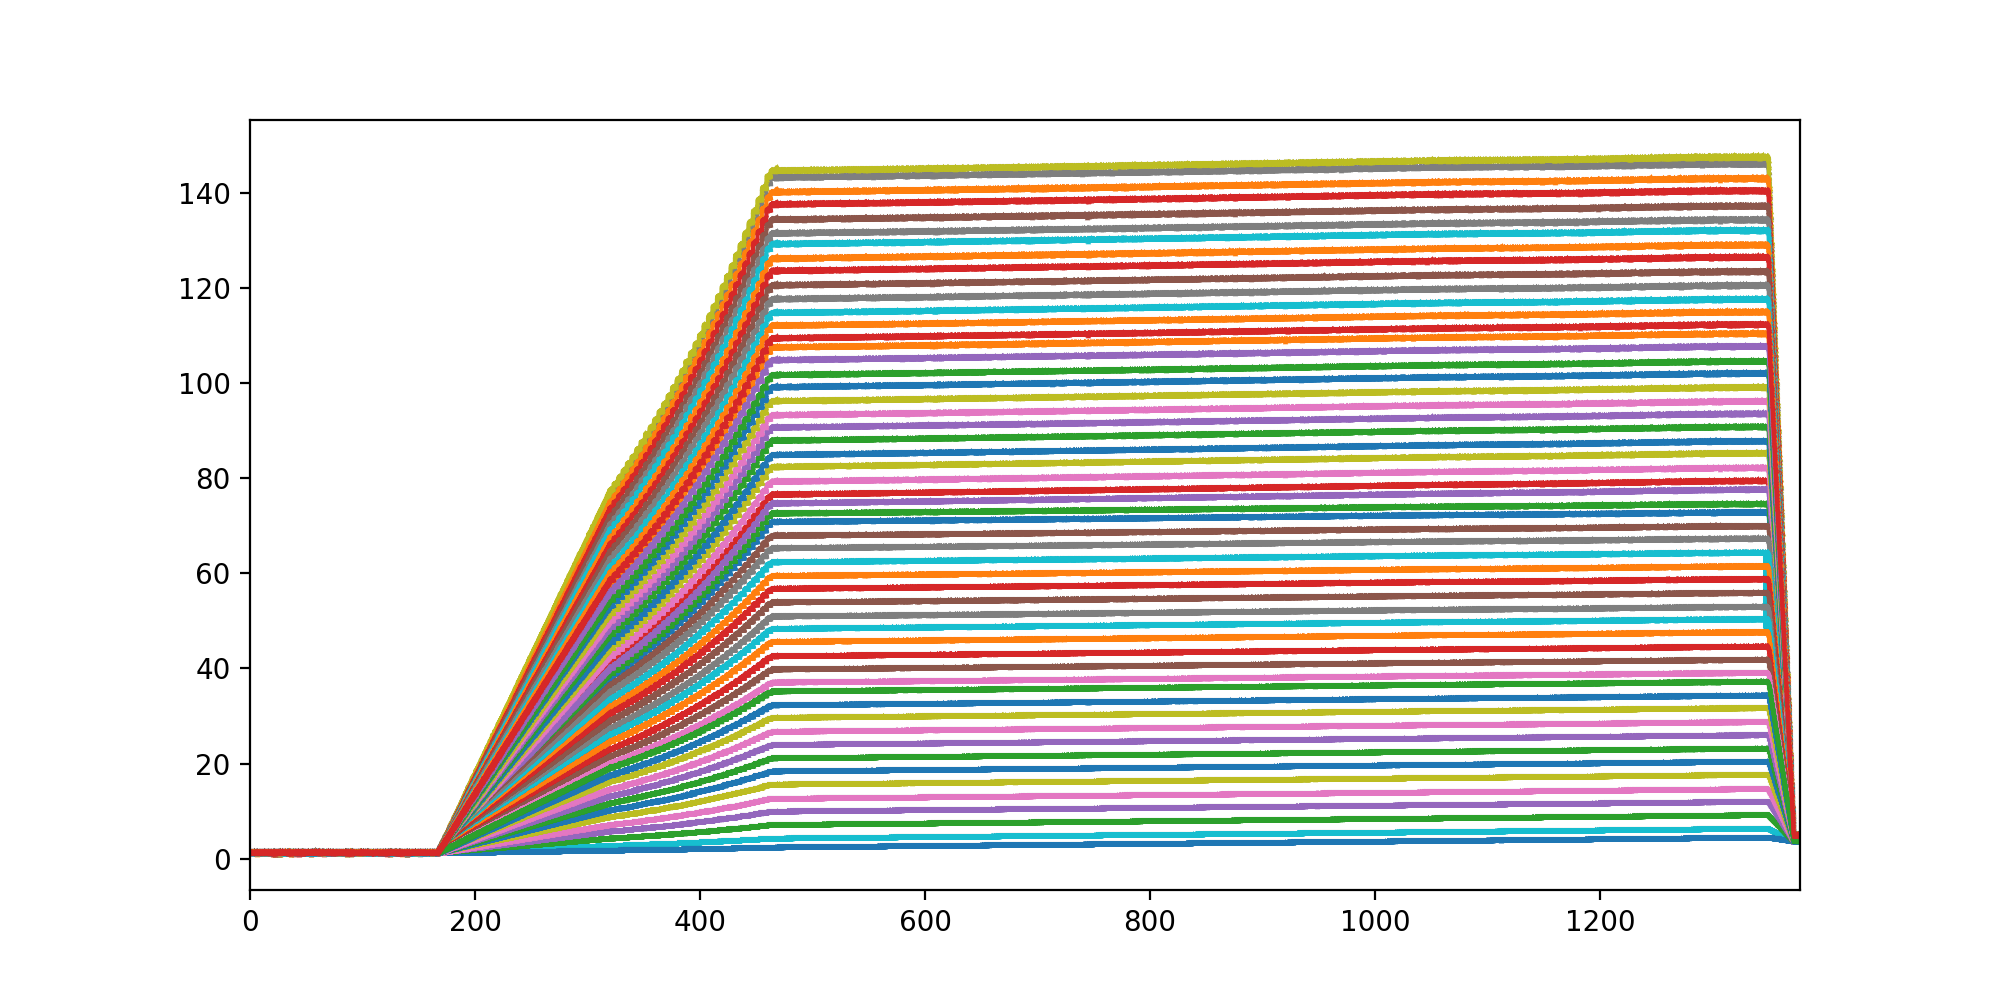

In [21]:
vfSecondResampledShortenedSyncedDf = pd.concat(vfSecondResampledShortenedSynced, axis = 1, ignore_index = True)
vfSecondResampledShortenedSyncedDf.plot(figsize=(10, 5), style='^-', markersize=0.3, legend=False)

# 7. Compare similarity between voltage feeler signals

## 7.1. L1 distance measure

In [22]:
L1Dist = []
for vfSeriesFirst, vfSeriesSecond in zip (vfFirstResampledShortenedSynced, vfSecondResampledShortenedSynced):
    L1Dist.append(LA.norm(vfSeriesFirst.values-vfSeriesSecond.values, 1))

## 7.2. L2 distance measure

In [23]:
L2Dist = []
for vfSeriesFirst, vfSeriesSecond in zip (vfFirstResampledShortenedSynced, vfSecondResampledShortenedSynced):
    L2Dist.append(LA.norm(vfSeriesFirst.values - vfSeriesSecond.values))

## 7.3. L-infinity distance measure

In [24]:
LInfDist = []
for vfSeriesFirst, vfSeriesSecond in zip (vfFirstResampledShortenedSynced, vfSecondResampledShortenedSynced):
    LInfDist.append(LA.norm(vfSeriesFirst.values - vfSeriesSecond.values, np.Inf))

# 8. Concatenate distance measures into a single DataFrame
- for comparison of similarity measures

In [25]:
outputDF = pd.DataFrame(columns = voltageNames)
outputDF.loc[len(outputDF.index) + 1] = L1Dist
outputDF.loc[len(outputDF.index) + 1] = L2Dist
outputDF.loc[len(outputDF.index) + 1] = LInfDist
outputDF

MB.A10R1:U_EARTH_RB  MB.A33R1:U_EARTH_RB  MB.A8R1:U_EARTH_RB  \
1          6431.638159          9799.819491         6600.122571   
2           196.265104           299.837787          197.224698   
3            13.781693            20.819713           13.627251   

   MB.B11R1:U_EARTH_RB  MB.B8R1:U_EARTH_RB  MB.C12R1:U_EARTH_RB  \
1          6954.248305         6814.743825          6175.345552   
2           211.803630          206.964572           188.243522   
3            14.541999           14.310179            12.903923   

   MB.C13R1:U_EARTH_RB  MB.C14R1:U_EARTH_RB  MB.C15R1:U_EARTH_RB  \
1          7324.633727          5936.288689          7483.263128   
2           224.856846           180.648847           228.593584   
3            15.469211            12.512471            15.580491   

   MB.C16R1:U_EARTH_RB  ...  MB.C25L2:U_EARTH_RB  MB.C26L2:U_EARTH_RB  \
1          5632.567521  ...          2110.779236         10978.860571   
2           170.156474  ...            63.427176           336.609833   
3            15.734165  ...             4.355124            22.904471   

   MB.C27L2:U_EARTH_RB  MB.C28L2:U_EARTH_RB  MB.C29L2:U_EARTH_RB  \
1          2345.903855         10721.989270          2621.463593   
2            69.931647           328.509984            79.410337   
3             4.785545            22.402812             5.497360   

   MB.C30L2:U_EARTH_RB  MB.C31L2:U_EARTH_RB  MB.C32L2:U_EARTH_RB  \
1         10460.493603          2875.181415         10200.653543   
2           320.590845            87.240254           312.642148   
3            22.031911             6.057264            21.322955   

   MB.C33L2:U_EARTH_RB  MB.C34L2:U_EARTH_RB  
1          3142.261044          9963.641840  
2            95.297737           305.122411  
3             6.572799            20.839020  

[3 rows x 54 columns]

- for storage of comparison results

In [26]:
l1DistNames = [str(col) + '_L1Dist' for col in voltageNames]
l2DistNames = [str(col) + '_L2Dist' for col in voltageNames]
lInfDistNames = [str(col) + '_LInfDist' for col in voltageNames]

columnNames = l1DistNames + l2DistNames + lInfDistNames
outputDF = pd.DataFrame(columns = columnNames)
outputDF.loc[len(outputDF.index) + 1] = L1Dist + L2Dist + LInfDist
outputDF

MB.A10R1:U_EARTH_RB_L1Dist  MB.A33R1:U_EARTH_RB_L1Dist  \
1                 6431.638159                 9799.819491   

   MB.A8R1:U_EARTH_RB_L1Dist  MB.B11R1:U_EARTH_RB_L1Dist  \
1                6600.122571                 6954.248305   

   MB.B8R1:U_EARTH_RB_L1Dist  MB.C12R1:U_EARTH_RB_L1Dist  \
1                6814.743825                 6175.345552   

   MB.C13R1:U_EARTH_RB_L1Dist  MB.C14R1:U_EARTH_RB_L1Dist  \
1                 7324.633727                 5936.288689   

   MB.C15R1:U_EARTH_RB_L1Dist  MB.C16R1:U_EARTH_RB_L1Dist  ...  \
1                 7483.263128                 5632.567521  ...   

   MB.C25L2:U_EARTH_RB_LInfDist  MB.C26L2:U_EARTH_RB_LInfDist  \
1                      4.355124                     22.904471   

   MB.C27L2:U_EARTH_RB_LInfDist  MB.C28L2:U_EARTH_RB_LInfDist  \
1                      4.785545                     22.402812   

   MB.C29L2:U_EARTH_RB_LInfDist  MB.C30L2:U_EARTH_RB_LInfDist  \
1                       5.49736                     22.031911   

   MB.C31L2:U_EARTH_RB_LInfDist  MB.C32L2:U_EARTH_RB_LInfDist  \
1                      6.057264                     21.322955   

   MB.C33L2:U_EARTH_RB_LInfDist  MB.C34L2:U_EARTH_RB_LInfDist  
1                      6.572799                      20.83902  

[1 rows x 162 columns]